This document shows how the SN parameters were chosen for Twinkles run 3. 

## The inputs are: 
- `TwinklesGalaxies`: All galaxies in catsim in spatial circular patch of the sky which encompasses the Twinkles CCD are downloaded into a csv file. In practice this is a 0.3 degrees patch around the field RA and field DEC of the OpSim field with fieldID 1427 as found in the OpSim database describing the current baseline cadence for LSST called `Minion_1016`. This is assumed to be in the file `Twinkles/data` and is a 48 MB file and can be downloaded [here](http://lsst.astro.washington.edu/simdata/SN_data/TWINKLES/CatSimGals_radp3.csv). You can use the script `Twinkles/examples/download_galaxies.py` to obtain a similar file.
- The Twinkles Code and Dependencies
- `SNSims` which depends on LSST catsim code. The version of this code used was [SNSims](https://github.com/rbiswas4/SNsims/releases/tag/v1.1.0)

## Basic Method:
- __Veto AGN Hosts__ Galaxies that are AGN lenses have been listed in the Twinkles repository. We veto these galaxies from the set obtained from `TwinklesGalaxies`
- __Expected Number of SN__ `SNSims` was used to find the expected number of SNIa in the Twinkles spatial region during the 10 years of LSST survey duration. This is based on an emperically observed `rate`. In order to get a good number of observations, we have increased the rate by a factor of 100, which corresponds to changing the constant multiplier in the rate $\alpha = 2.6e-3$ . This gives us the expected number of SNIa in redshift bins of equal size of $\Delta z_{\rm{bin}} = 0.05 .$ We only consider SNIa to a redshift of 1.2, which is about as high as people have investigated and somewhat higher than the highest redshift at which LSST is often expected to have a useful sample  ($z\sim 0.9$).
- __Host Selection and SN Redshifts__  We select a number CatSim galaxies in each redshift bin, such that the number is drawn from a Poisson distribution with mean equal to expected number of SNIa in that redshift bin during the ten years in the Twinkles Spatial region, and are randomly selected to be SNIa hosts. The redshifts of these galaxies are taken as the redshift of the SNIa, and this defines the exact redshift distribution of the sample. Each selected galaxy is assigned a single SNIa.
- __Angular Position of SN (separation from host)__ 
    - __Host Components__ These CatSim galaxies have (a) only bulges (b) only disks or (c) bulges and disks with each of the two components having an appropriate sersic index of 1, or 4. If the galaxy has a single component, the SN is assumed to be in that component. If it has both components (c), the SN are chosen to be in disks or bulges with equal probability.
    - __Radial Position Relative to Host Center__ The sersic index is used to define a light profile, and the SN radial position is assumed to follow this profile. Thus, radial samples are drawn from the profile of the appropriate host component
    - __Angular Position Relative to Host Center__ The ratio between the semi-major and semi-minor axes of the host component is used to sample the non-uniform angular distribution due to ellipticity and the position angle of the host component is used to rotate the sampled position appropriately
- __SN parameters__ The SALT2 parameters of the SN are chosen by randomly sampling independent normal distributions in `x1` and `c`. Finally, the amplitude is sampled by assuming a normal distribution of the standardized absolute magnitude with a 'coherent' dispersion of 0.15 mags about a mean of -19.3 mags in the rest frame (energy counting) Bessell B Band. The actual values of `x0` corresponding to this are found by using the Tripp Relation with $\alpha_{\rm{Tripp}}=0.11$ and $\beta_{\rm{Tripp}}=3.11$. In this method there are (unfortunately) no correlations between the host properties and the SN properties are dropped.  
- __SNIDs__ Since no two SN have the same host, we choose the galaxy ids as the SN id. Further since we are only doing a single tile, we do not use the `galtileid` which is a unique id for each galaxy across the LSST sky, but only use the `id` which is unique only on a particular tile.
- __Hostless Twins__ In order to be able to study our abilty to do forced photometry on transients like supernovae, and the impact that host galaxies have on it, we place each SN in the SN sample described above at a spatial position in the Twinkles spatial region drawn with equal probabilty with the exact same SN parameters. The snid of these Twin supernovae are exactly $10^8$ greater then their snid in the former sample which is sufficient to ensure that there are no clashes on ids. This ensures that at most times, we will observe an identical supernova somewhere else in the field, so SN and observing conditions will be the same while the local environment (galaxy background, possible MW extinction, though everyting is too close for that to vary much) and spatially varying quantities will be different. 

## Notes: 
- The SN are selected using random number generators in a reproducible way, however the downloaded file for galaxies is not ordered. Therefore, if you do not download the linked file, you are should obtain a statistically equivalent SN set, but not an identical SN parameter set. 

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/miniconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
from copy import deepcopy

In [4]:
import opsimsummary as oss

In [5]:
from lsst.utils import getPackageDir

In [6]:
from desc.twinkles import read_catsimInstCat

/Users/rbiswas/src/LSST_el_Capitan/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:439: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/rbiswas/src/LSST_el_Capitan/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:439: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/rbiswas/src/LSST_el_Capitan/sims_catalogs/python/lsst/sims/catalogs/db/dbConnection.py:424: UserWarning: duplicate object identifier galaxyDisk specified. This will override previous definition on line 344 of /Users/rbiswas/src/LSST_el_Capitan/sims_catUtils/python/lsst/sims/catUtils/baseCatalogModels/GalaxyModels.py
  (srcline, srcfile))
/Users/rbiswas/src/LSST_el_Capitan/sims_catalogs/python/lsst/

In [36]:
import healpy as hp

In [34]:
from snsims import TwinklesSim, SimpleSALTDist, CatSimPositionSampling, Tiling

In [8]:
varlist = ['id', 'galtileid', 'snid', 'snra', 'sndec', 't0', 'x0', 'x1', 'c', 'z']

## Veto Agn Hosts

In [9]:
twinklesdir = getPackageDir('Twinkles')

The file `agn_host_id.txt` has an `id` column which is hard to match against the supernova. The file `galtileid_catalog.csv` has both `id` and `galtileid` columns.  The `galtileid` column is not the `galtileid` of the `GalaxyTiled` database object, and has been mangled for the use of `PhoSim` which does not work correctly for large integers. Indeed, the `galtileid` 
variable in the agns is the same as the `id` variable in the `GalaxyTiled` database object, and instance catalogs that use it as an underlying `db_obj`.

Our strategy here is to use these two files to obtain the mangled `galtileid` or the `id` of the usual instance catalogs derived from using `GalaxyTiled` as the underlying db_obj. We will then use the `id` column of such an instance catalog to find the galaxies that are lensing AGN, and will veto these as candidate hosts for SN.

In [10]:
agngaltileIdFile = os.path.join(twinklesdir, 'data', 'agn_hosts.csv')
agn_df = pd.read_csv(agngaltileIdFile)

In [11]:
agn_df.head()

,Unnamed: 0,galtileid,uniqueid,ra,dec,redshift
0,181,483573,495178778,53.257016,-27.270674,0.494
1,268,10291163,10538150938,53.236345,-27.290742,0.808
2,563,12809797,13117232154,53.263454,-27.278359,0.364
3,811,6916769,7082771482,53.166742,-27.684328,0.376
4,943,8253557,8451642394,53.180439,-27.672666,0.580


In [12]:
agn_df.galtileid.size

198

In [13]:
galFile = os.path.join(twinklesdir, 'data', 'CatSimGals_radp3.csv')
os.path.exists(galFile)
gals = read_catsimInstCat(galFile)
print(len(gals))

243476


In [14]:
gals.id.unique().size

243476

In [15]:
gals.columns

Index([u'id', u'galtileid', u'raJ2000', u'decJ2000', u'redshift', u'a_d',
       u'b_d', u'pa_disk', u'sindexDisk', u'DiskHalfLightRadius', u'a_b',
       u'b_b', u'pa_bulge', u'sindexBulge', u'BulgeHalfLightRadius',
       u'mass_stellar', u'mass_gas', u'mass_halo', u'mass_bulge',
       u'sedFilenameDisk', u'sedFilenameBulge', u'log10BulgeToTotLSSTrFlux'],
      dtype='object')

In [16]:
agntups = tuple(agn_df.galtileid.tolist())
gals = gals.query('id not in @agntups')

In [17]:
len(gals)

243278

gals is a dataframe containing information about galaxies which are not AGN hosts

## SN Parameters

In [18]:
from astropy.cosmology import FlatLambdaCDM

In [19]:
cosmo = FlatLambdaCDM(H0=73.0, Om0=0.25)

In [20]:
# in degrees
TwinklesArea = np.pi * 0.3**2

`TwinklesSim` is a class representing the distribution of SN parameters and positions given a power law equation for SN rates, a sample of catsim galaxies, and the time duration and time interval of observation. Thus it performs all the functionality required for sampling the parameters of the hosted SNIa and the sample of AGN-less catsim galaxies. The actual calls required to do this are given below, but here,  we will summarize the codes used to perform the operations. 

__Expected Number of SN__: The  class `PowerLawRates` deals with calculating the expected number of SN in a spatial area in uniform redshift bins. 
__Host Selection and SN Redshifts__: The class `TwinklesRates` inherits from `PowerLawRates` and has the additional functionality of assigning hosts in the correct redshift bins statistically, in order to obtain the realization of SNIa redshifts. 
__Angular Position of SN (separation from host)__ `TwinklesSim` inherits from `TwinklesRates` and uses the host matching there along with sampling of the angular positions with functionality in `CatSimPositionSampling`.


In [22]:
tsim = TwinklesSim(catsimgaldf=gals, rng=np.random.RandomState(0), fieldArea=TwinklesArea,
                   cosmo=cosmo, numBins=24
                    )

/Users/rbiswas/.local/lib/python2.7/site-packages/snsims/paramDistribution.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  galsdf['probHist'] = galsdf.redshiftBin.apply(self.probHost)
/Users/rbiswas/.local/lib/python2.7/site-packages/snsims/paramDistribution.py:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  galsdf['hostAssignmentRandom'] = self.rng.uniform(size=len(galsdf))
/usr/local/miniconda/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [23]:
tsim.snparamdf.head()

,M,Mabs,c,mB,t0,x0,x1,z,id,galtileid,...,bulgeRadialPos,diskRadialPos,bulgeAngle,diskAngle,DeltaRaDisk,DeltaRaBulge,DeltaDecDisk,DeltaDecBulge,snra,sndec
snid,,,,,,,,,,,,,,,,,,,,,
8206769,0.165184,-19.369516,-0.025170,23.845774,62728.871253,0.000005,-0.783170,0.7286,8206769,60008206769,...,0.0,0.123480,NaN,-52.791583,-0.090504,NaN,-0.084002,NaN,53.208652,-27.291327
14159772,0.278276,-19.075427,-0.057076,25.395252,59590.365909,0.000001,-0.900533,1.1552,14159772,60014159772,...,0.0,0.016072,NaN,7.428601,-0.008900,NaN,0.013383,NaN,53.208376,-27.290750
2864869,0.736539,-18.621764,-0.225481,25.143418,63213.231719,0.000001,-0.259369,0.8922,2864869,60002864869,...,0.0,0.882331,NaN,58.315735,-0.549376,NaN,-0.690431,NaN,53.204026,-27.294257
8718460,-0.298495,-19.570323,0.060792,24.868692,61181.541954,0.000002,0.978256,1.1419,8718460,60008718460,...,0.0,0.206793,NaN,96.831652,0.061494,NaN,0.197439,NaN,53.207674,-27.286143
7898978,0.033437,-19.219225,0.013896,24.592289,59843.885293,0.000002,-0.700624,0.9075,7898978,60007898978,...,0.0,0.099051,NaN,156.324302,0.089029,NaN,0.043416,NaN,53.204129,-27.288226


In [24]:
tsim.snparamdf.reset_index().to_csv('snparams.csv', index=False)

In [25]:
!head snparams.csv

snid,M,Mabs,c,mB,t0,x0,x1,z,id,galtileid,raJ2000,decJ2000,redshift,a_d,b_d,pa_disk,sindexDisk,DiskHalfLightRadius,a_b,b_b,pa_bulge,sindexBulge,BulgeHalfLightRadius,mass_stellar,mass_gas,mass_halo,mass_bulge,sedFilenameDisk,sedFilenameBulge,log10BulgeToTotLSSTrFlux,redshiftBin,probHist,hostAssignmentRandom,isinDisk,bulgeRadialPos,diskRadialPos,bulgeAngle,diskAngle,DeltaRaDisk,DeltaRaBulge,DeltaDecDisk,DeltaDecBulge,snra,sndec
8206769,0.165183538224,-19.3695159684,-0.0251703394203,23.8457738737,62728.8712531,4.59792198492e-06,-0.783169749492,0.7286,8206769,60008206769,0.9286666,-0.4763231,0.7286,0.5034,0.2882,174.3423,1,0.5034,0.0,0.0,0.0,4,0.0,0.0065,0.0992,1.8934,0.0, Exp.20E09.0005Z.spec, None,-1000.0,14,0.572420443587,0.138182951349,1,0.0,0.123480106327,,-52.7915832681,-0.0905041674894,,-0.0840019781049,,53.2086516147,-27.2913266485
14159772,0.278276486695,-19.0754267365,-0.0570757582693,25.3952522307,59590.3659091,1.10382247296e-06,-0.900532779362,1.1552,14159772,60014159772,0.92866

In [26]:
tsim.snparamdf.reset_index()[varlist].to_csv('HostedSN.csv', index=False)

In [27]:
tsim.snparamdf.head()

,M,Mabs,c,mB,t0,x0,x1,z,id,galtileid,...,bulgeRadialPos,diskRadialPos,bulgeAngle,diskAngle,DeltaRaDisk,DeltaRaBulge,DeltaDecDisk,DeltaDecBulge,snra,sndec
snid,,,,,,,,,,,,,,,,,,,,,
8206769,0.165184,-19.369516,-0.025170,23.845774,62728.871253,0.000005,-0.783170,0.7286,8206769,60008206769,...,0.0,0.123480,NaN,-52.791583,-0.090504,NaN,-0.084002,NaN,53.208652,-27.291327
14159772,0.278276,-19.075427,-0.057076,25.395252,59590.365909,0.000001,-0.900533,1.1552,14159772,60014159772,...,0.0,0.016072,NaN,7.428601,-0.008900,NaN,0.013383,NaN,53.208376,-27.290750
2864869,0.736539,-18.621764,-0.225481,25.143418,63213.231719,0.000001,-0.259369,0.8922,2864869,60002864869,...,0.0,0.882331,NaN,58.315735,-0.549376,NaN,-0.690431,NaN,53.204026,-27.294257
8718460,-0.298495,-19.570323,0.060792,24.868692,61181.541954,0.000002,0.978256,1.1419,8718460,60008718460,...,0.0,0.206793,NaN,96.831652,0.061494,NaN,0.197439,NaN,53.207674,-27.286143
7898978,0.033437,-19.219225,0.013896,24.592289,59843.885293,0.000002,-0.700624,0.9075,7898978,60007898978,...,0.0,0.099051,NaN,156.324302,0.089029,NaN,0.043416,NaN,53.204129,-27.288226


In [28]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:////Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db')
pts = pd.read_sql_query('SELECT * FROM Summary WHERE FieldID == 1427', engine)
pts.drop_duplicates(subset='obsHistID', inplace=True)

In [29]:
pts.head()

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,230,1016,56,1427,0.925184,-0.4789,r,12057,59580.139555,0,...,0.0,84.646287,0.866285,0.0,0.0,0.755889,140.0,24.070428,0.907976,-0.505351
1,231,1016,56,1427,0.925184,-0.4789,r,12093,59580.139972,0,...,0.0,84.969264,0.791241,0.0,0.0,0.000000,2.0,24.143180,0.907976,-0.505351
2,232,1016,56,1427,0.925184,-0.4789,r,12129,59580.140389,0,...,0.0,85.037385,0.791241,0.0,0.0,0.000000,2.0,24.141983,0.907976,-0.505351
3,233,1016,56,1427,0.925184,-0.4789,r,12165,59580.140805,0,...,0.0,85.105955,0.859965,0.0,0.0,0.000000,2.0,24.068792,0.907976,-0.505351
4,234,1016,56,1427,0.925184,-0.4789,r,12201,59580.141222,0,...,0.0,85.174974,0.859965,0.0,0.0,0.000000,2.0,24.067582,0.907976,-0.505351


In [30]:
class TwinSN(object):
    def __init__(self, rng, snparamsDF, pointings, radius):
        self.theta_c = - np.degrees(pointings.iloc[0].fieldDec) + 90.0
        self.phi_c = np.degrees(pointings.iloc[0].fieldRA)
        self.numSN = len(snparamsDF)
        self.snParams = snparamsDF.copy().reset_index()
        self.radius = radius
        self.rng = rng
        self._positions = None
        self.varlist = ['id', 'galtileid', 'snid', 'snra', 'sndec', 't0', 'x0', 'x1', 'c', 'z']
    def randomPositions(self, radius=None):
        """
        Random positions on a sphere within angular radius set by parameter
        or self.radius if radius is None of self.theta_c and self.phi_c
        radius : float, units of degrees
            max angular radius within which the points are being sampled
        """
        if radius is None:
            radius == self.radius
        pos = Tiling.samplePatchOnSphere(phi=self.phi_c, 
                                         theta=self.theta_c,
                                         delta=radius, size=2*self.numSN,
                                         rng=self.rng )
        positions = pd.DataFrame(dict(phi=pos[0], theta=pos[1]))
        ang_c = hp.ang2vec(np.radians(self.theta_c), np.radians(self.phi_c))
        angs = hp.ang2vec(positions.theta.apply(np.radians).values, 
                                positions.phi.apply(np.radians).values)
        positions['vec'] = angs.tolist()
        positions['cosRadius'] = np.dot(angs, ang_c)
        positions['radius'] = np.degrees(np.arccos(positions.cosRadius))
        positions['inreg'] = positions.cosRadius > np.cos(np.radians(radius))
        return positions
    @property
    def selectedPositions(self):
        if self._positions is None:
            rand = self.randomPositions(self.radius)
            self._positions = rand.query('inreg == True').iloc[:self.numSN]
        return self._positions
    
    @property
    def snra(self):
        return self.selectedPositions.phi.values
    
    @property
    def sndec(self):
        return -self.selectedPositions.theta.values + 90.0
    @property
    def snids(self):
        return self.snParams.reset_index().snid.values + np.int(1.0e8)

    def writeFile(self, filename='hostLessSN.csv'):
        self.snParams.snra = self.snra
        self.snParams.sndec = self.sndec
        self.snParams.snid = self.snids
        self.snParams[self.varlist].to_csv(filename, index=False)

In [31]:
tsn = TwinSN(rng=np.random.RandomState(600), snparamsDF=tsim.snparamdf, pointings=pts.iloc[:5], 
            radius=0.3)

In [32]:
tsn.snParams.head()

,snid,M,Mabs,c,mB,t0,x0,x1,z,id,...,bulgeRadialPos,diskRadialPos,bulgeAngle,diskAngle,DeltaRaDisk,DeltaRaBulge,DeltaDecDisk,DeltaDecBulge,snra,sndec
0,8206769,0.165184,-19.369516,-0.025170,23.845774,62728.871253,0.000005,-0.783170,0.7286,8206769,...,0.0,0.123480,NaN,-52.791583,-0.090504,NaN,-0.084002,NaN,53.208652,-27.291327
1,14159772,0.278276,-19.075427,-0.057076,25.395252,59590.365909,0.000001,-0.900533,1.1552,14159772,...,0.0,0.016072,NaN,7.428601,-0.008900,NaN,0.013383,NaN,53.208376,-27.290750
2,2864869,0.736539,-18.621764,-0.225481,25.143418,63213.231719,0.000001,-0.259369,0.8922,2864869,...,0.0,0.882331,NaN,58.315735,-0.549376,NaN,-0.690431,NaN,53.204026,-27.294257
3,8718460,-0.298495,-19.570323,0.060792,24.868692,61181.541954,0.000002,0.978256,1.1419,8718460,...,0.0,0.206793,NaN,96.831652,0.061494,NaN,0.197439,NaN,53.207674,-27.286143
4,7898978,0.033437,-19.219225,0.013896,24.592289,59843.885293,0.000002,-0.700624,0.9075,7898978,...,0.0,0.099051,NaN,156.324302,0.089029,NaN,0.043416,NaN,53.204129,-27.288226


In [37]:
tsn.writeFile()

In [38]:
!head hostLessSN.csv

id,galtileid,snid,snra,sndec,t0,x0,x1,c,z
8206769,60008206769,108206769,53.073083396,-27.6826882565,62728.8712531,4.59792198492e-06,-0.783169749492,-0.0251703394203,0.7286
14159772,60014159772,114159772,53.0030879645,-27.6786437027,59590.3659091,1.10382247296e-06,-0.900532779362,-0.0570757582693,1.1552
2864869,60002864869,102864869,52.8665611188,-27.5702914454,63213.231719,1.38570732199e-06,-0.259368922661,-0.225480533471,0.8922
8718460,60008718460,108718460,53.0035349868,-27.4658180211,61181.541954,1.7803248928e-06,0.978255580335,0.0607921573632,1.1419
7898978,60007898978,107898978,53.2039930689,-27.4107822763,59843.8852934,2.31118898225e-06,-0.70062428187,0.0138955427337,0.9075
2654618,60002654618,102654618,53.2156478827,-27.3933047274,62517.0925188,1.99906761434e-06,-0.0707924087456,0.0852891659243,1.1024
2485645,60002485645,102485645,52.8582473381,-27.5880295478,61520.2450358,3.07614646054e-06,-0.142130466844,-0.0378608705683,0.754
734644,60000734644,100734644,53.0445462823,-27.703

## Statistics

In [41]:
df = pd.concat([tsn.snParams[tsn.varlist], tsim.snparamdf.reset_index()[varlist]])

In [44]:
len(df)/2.0

59263.0

In [45]:
df.snid.unique().size == len(df)

True

In [46]:
df.rem = df.snid - df.id

In [47]:
df.rem.unique()

array([100000000,         0])

In [48]:
df.snra.describe()

count    118526.000000
mean         53.009794
std           0.163720
min          52.671219
25%          52.877115
50%          53.010570
75%          53.142580
max          53.347177
Name: snra, dtype: float64

In [49]:
df.sndec.describe()

count    118526.000000
mean        -27.438723
std           0.151069
min         -27.738737
25%         -27.561898
50%         -27.439129
75%         -27.314991
max         -27.139242
Name: sndec, dtype: float64

In [50]:
binsize = 128 * 0.2 /3600.

In [59]:
df['raind'] = (df.snra - 52.65 ) // binsize
df['decind'] = (df.snra - -27.75 ) // binsize
df['t0ind']  = (df.t0 - 59580.) // 50.0

In [60]:
df.raind = df.raind.astype(int)
df.decind = df.decind.astype(int)
df.t0ind = df.t0ind.astype(int)

In [61]:
df.columns

Index([u'id', u'galtileid', u'snid', u'snra', u'sndec', u't0', u'x0', u'x1',
       u'c', u'z', u'raind', u'decind', u't0ind'],
      dtype='object')

In [80]:
grouped = df.groupby(['raind', 'decind', 't0ind'])

In [81]:
counts = grouped.z.count()

In [85]:
counts.sort()

/usr/local/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


In [87]:
counts.query

raind  decind   t0ind
2.0    11309.0  2.0      False
94.0   11401.0  18.0     False
                15.0     False
                13.0     False
                12.0     False
                11.0     False
                10.0     False
       11400.0  44.0     False
       11401.0  8.0      False
                5.0      False
       11400.0  45.0     False
       11401.0  4.0      False
       11400.0  70.0     False
                67.0     False
                52.0     False
       11401.0  7.0      False
92.0   11399.0  26.0     False
93.0   11400.0  44.0     False
                36.0     False
       11399.0  1.0      False
92.0   11399.0  70.0     False
94.0   11401.0  2.0      False
       11400.0  42.0     False
93.0   11400.0  47.0     False
                62.0     False
89.0   11395.0  40.0     False
88.0   11395.0  54.0     False
                27.0     False
89.0   11396.0  20.0     False
94.0   11401.0  22.0     False
                         ...  
23.0   11329.0  4

In [83]:
np.bincount(counts).sum()

13336

<Container object of 3 artists>

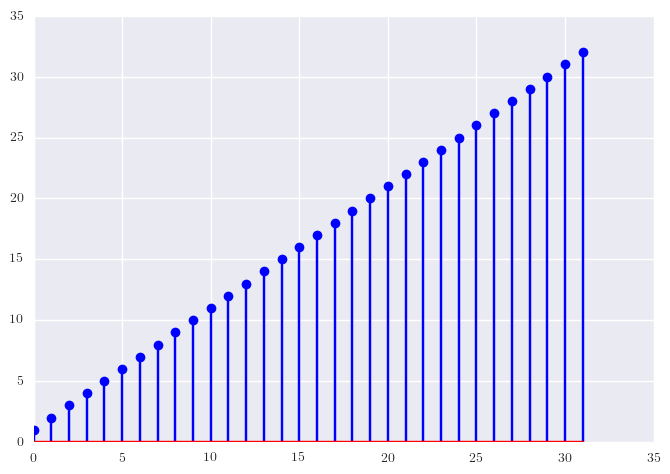

In [84]:
plt.stem(counts.unique())

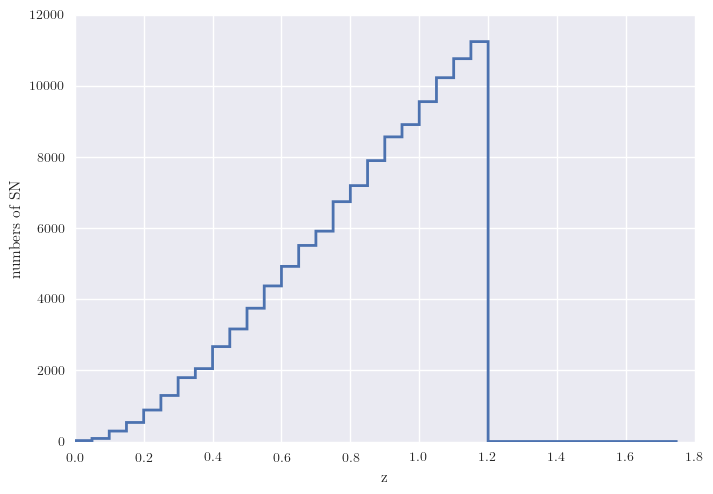

In [91]:
fig, ax = plt.subplots()
df.z.hist(bins=np.arange(0.,1.8, 0.05), histtype='step', lw=2, ax=ax)
ax.set_xlabel('z')
ax.set_ylabel('numbers of SN')

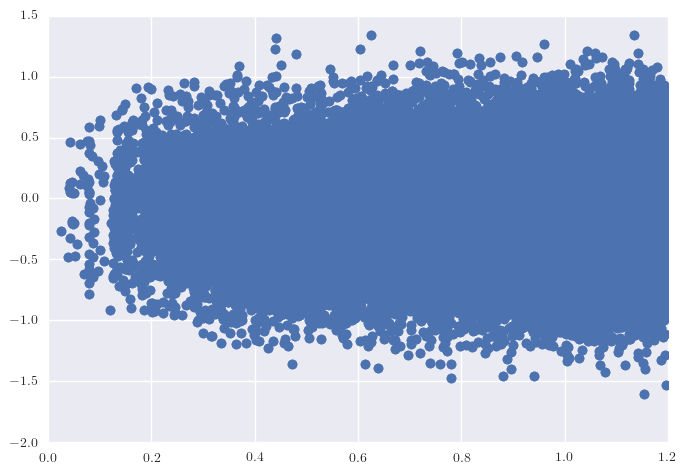

In [96]:
fig, ax = plt.subplots()
ax.plot(df.z, -2.5 * np.log10(df.x0) - cosmo.distmod(df.z) +29.7, 'o')

In [97]:
import analyzeSN as ans

In [98]:
import sncosmo